In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import glob

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


# Import Data

In [2]:
data_files = glob.glob('../data/clean/monthly/*.csv')
rawdata_df = pd.concat(tqdm((pd.read_csv(x) for x in data_files), total = len(data_files)))
rawdata_df.sample(10)

,date,ticker,mod_time_m,time_m,price,datetime
138826,2019-12-27,CTLT,128,10:44:48.728,56.11,2019-12-27 10:45:00
98200,2020-08-19,SCHW,117,09:49:59.002,35.65,2020-08-19 09:50:00
153210,2020-04-30,ALL,135,11:19:51.823,103.00,2020-04-30 11:20:00
60079,2020-07-13,KMX,134,11:14:58.631,88.67,2020-07-13 11:15:00
48010,2019-11-11,ANTM,155,12:59:59.647,278.81,2019-11-11 13:00:00
44416,2019-11-08,GOOG,149,12:29:43.849,1311.71,2019-11-08 12:30:00
91224,2019-12-18,AFL,166,13:54:58.309,53.05,2019-12-18 13:55:00
56816,2020-08-12,AVB,147,12:19:31.913,151.33,2020-08-12 12:20:00
7028,2020-07-01,GOOG,122,10:14:59.153,1424.84,2020-07-01 10:15:00
163836,2019-10-31,AAL,162,13:34:45.191,30.02,2019-10-31 13:35:00


# Clean Data

In [4]:
# Copy data for cleaning
data_df = rawdata_df.copy()

In [5]:
# Fix dates
data_df['date'] = pd.to_datetime(data_df['date'])
data_df['datetime'] = pd.to_datetime(data_df['datetime'])
data_df['time'] = data_df['datetime'].dt.time
data_df = data_df.drop(['time_m', 'mod_time_m'], axis = 1)
data_df = data_df.sort_values(by = ['ticker', 'date', 'datetime'])

In [6]:
# Adjust stock splits
data_df.loc[(data_df["ticker"] == "AAPL") & (data_df["datetime"] < "2020-08-31"), "price"] = (
    data_df.loc[(data_df["ticker"] == "AAPL") & (data_df["datetime"] < "2020-08-31"), "price"] / 5
)

In [7]:
%%time
# Prices
data_df['log_price'] = np.log(data_df['price'])
data_df['return'] = data_df.groupby(['ticker', 'date'])['log_price'].transform(pd.Series.diff)

CPU times: user 8.03 s, sys: 359 ms, total: 8.39 s
Wall time: 8.37 s


In [8]:
%%time
# Return vars
data_df["return_p2"] = np.power(data_df["return"], 2)
data_df["return_p4"] = np.power(data_df["return"], 4)
data_df["return_lag1"] = data_df.groupby(["ticker", "date"])["return"].shift(1)
data_df["return_bp"] = np.abs(np.multiply(data_df["return"], data_df["return_lag1"]))

# BV
data_df["bipower_var_daily"] = data_df.groupby(["ticker", "date"])["return_bp"].transform("sum") * (
    78 / 77
)
data_df["bipower_var_tod"] = data_df.groupby(["ticker", "time"])["return_bp"].transform("mean")

# Jump detection
alpha = 3.5
data_df["tod_correction"] = np.divide(
    data_df["bipower_var_tod"], data_df.groupby(["ticker"])["bipower_var_tod"].transform("mean")
)
data_df["jump_cut"] = (
    alpha * np.sqrt(data_df["bipower_var_daily"] * data_df["tod_correction"]) * ((1 / 78) ** (0.49))
)
data_df['is_jump'] = np.abs(data_df['return']) > data_df['jump_cut']

## Filtered diffusive returns
# Main
data_df['return_d'] = data_df['return']*(1-data_df['is_jump'])
data_df['return_d_pos'] = data_df['return_d']*(data_df['return_d'] > 0)
data_df['return_d_neg'] = data_df['return_d']*(data_df['return_d'] < 0)
# Semi
data_df['return_d_p2'] = np.power(data_df['return_d'], 2)
data_df['return_d_p4'] = np.power(data_df['return_d'], 4)
data_df['return_d_p2_pos'] = np.power(data_df['return_d_pos'], 2)
data_df['return_d_p4_pos'] = np.power(data_df['return_d_pos'], 4)
data_df['return_d_p2_neg'] = np.power(data_df['return_d_neg'], 2)
data_df['return_d_p4_neg'] = np.power(data_df['return_d_neg'], 4)

## Filtered jump returns
# Main
data_df['return_j'] = data_df['return']*(data_df['is_jump'])
data_df['return_j_pos'] = data_df['return_j']*(data_df['return_j'] > 0)
data_df['return_j_neg'] = data_df['return_j']*(data_df['return_j'] < 0)
# Semi
data_df['return_j_p2'] = np.power(data_df['return_j'], 2)
data_df['return_j_p4'] = np.power(data_df['return_j'], 4)
data_df['return_j_p2_pos'] = np.power(data_df['return_j_pos'], 2)
data_df['return_j_p4_pos'] = np.power(data_df['return_j_pos'], 4)
data_df['return_j_p2_neg'] = np.power(data_df['return_j_neg'], 2)
data_df['return_j_p4_neg'] = np.power(data_df['return_j_neg'], 4)

data_df.head()

CPU times: user 1.77 s, sys: 625 ms, total: 2.39 s
Wall time: 1.52 s


,date,ticker,price,datetime,time,log_price,return,return_p2,return_p4,return_lag1,...,return_d_p4_neg,return_j,return_j_pos,return_j_neg,return_j_p2,return_j_p4,return_j_p2_pos,return_j_p4_pos,return_j_p2_neg,return_j_p4_neg
0,2019-10-01,A,76.75,2019-10-01 09:35:00,09:35:00,4.340553,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-10-01,A,76.71,2019-10-01 09:40:00,09:40:00,4.340032,-0.000521,2.717625e-07,7.385488e-14,NaN,...,7.385488e-14,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-10-01,A,76.79,2019-10-01 09:45:00,09:45:00,4.341074,0.001042,1.086484e-06,1.180447e-12,-0.000521,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-10-01,A,76.66,2019-10-01 09:50:00,09:50:00,4.339380,-0.001694,2.870867e-06,8.241879e-12,0.001042,...,8.241879e-12,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-10-01,A,76.58,2019-10-01 09:55:00,09:55:00,4.338336,-0.001044,1.090174e-06,1.188479e-12,-0.001694,...,1.188479e-12,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# TOD check
#data_df.query('ticker == "AAPL"').plot(x = 'time', y = 'tod_correction')

In [10]:
# Daily sums
columns_return = [x for x in data_df.columns if 'return' in x]
data_daily_df = data_df.groupby(["ticker", "date"])[columns_return].sum().reset_index()
data_daily_df

,ticker,date,return,return_p2,return_p4,return_lag1,return_bp,return_d,return_d_pos,return_d_neg,...,return_d_p4_neg,return_j,return_j_pos,return_j_neg,return_j_p2,return_j_p4,return_j_p2_pos,return_j_p4_pos,return_j_p2_neg,return_j_p4_neg
0,A,2019-10-01,-0.025736,0.000151,1.701416e-09,-0.025736,0.000087,-0.015911,0.028484,-0.044395,...,1.748195e-10,-0.009825,0.000000,-0.009825,0.000050,1.406676e-09,0.000000,0.000000e+00,0.000050,1.406676e-09
1,A,2019-10-02,-0.009498,0.000147,1.041992e-09,-0.009362,0.000082,-0.012628,0.032481,-0.045108,...,7.908565e-10,0.003129,0.003129,0.000000,0.000010,9.591391e-11,0.000010,9.591391e-11,0.000000,0.000000e+00
2,A,2019-10-03,0.007951,0.000227,6.477650e-09,0.004561,0.000084,0.003049,0.033840,-0.030791,...,1.800937e-10,0.004902,0.013128,-0.008226,0.000128,5.976773e-09,0.000060,1.397972e-09,0.000068,4.578801e-09
3,A,2019-10-04,0.019834,0.000101,7.989158e-10,0.018845,0.000064,0.019834,0.042165,-0.022331,...,6.024417e-10,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00
4,A,2019-10-07,-0.002660,0.000107,4.300471e-10,-0.002527,0.000061,-0.003058,0.031445,-0.034504,...,1.492402e-10,0.000398,0.003183,-0.002785,0.000018,1.628927e-10,0.000010,1.027050e-10,0.000008,6.018775e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22358,T,2020-08-25,-0.006833,0.000026,4.709700e-11,-0.006498,0.000017,-0.004494,0.012870,-0.017364,...,1.227008e-11,-0.002338,0.000000,-0.002338,0.000005,2.990032e-11,0.000000,0.000000e+00,0.000005,2.990032e-11
22359,T,2020-08-26,0.006018,0.000031,4.004627e-11,0.005518,0.000022,0.004020,0.020764,-0.016744,...,7.222337e-12,0.001998,0.001998,0.000000,0.000004,1.593618e-11,0.000004,1.593618e-11,0.000000,0.000000e+00
22360,T,2020-08-27,-0.006004,0.000055,2.302273e-10,-0.005335,0.000032,-0.008514,0.016858,-0.025372,...,1.698908e-10,0.002510,0.002510,0.000000,0.000006,3.968060e-11,0.000006,3.968060e-11,0.000000,0.000000e+00
22361,T,2020-08-28,0.004838,0.000027,4.307566e-11,0.003339,0.000015,0.006340,0.019199,-0.012860,...,2.572140e-11,-0.001502,0.000000,-0.001502,0.000002,5.087896e-12,0.000000,0.000000e+00,0.000002,5.087896e-12


# Autocorrelation

(-0.5, 50.0)

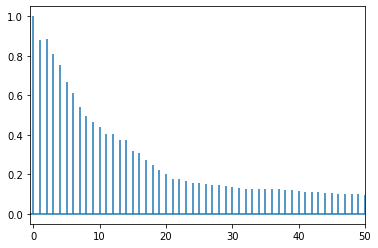

In [11]:
plt.acorr(data_daily_df.query('ticker == "A"').sort_values(by = 'date')['return_d_p2'], maxlags = 50)
plt.xlim(-0.5, 50)

(-0.5, 50.0)

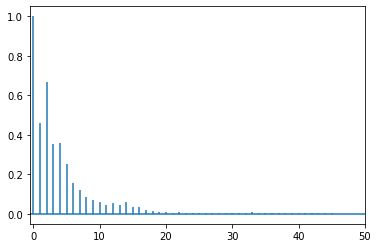

In [12]:
plt.acorr(data_daily_df.query('ticker == "A"').sort_values(by = 'date')['return_d_p4'], maxlags = 50)
plt.xlim(-0.5, 50)

(-0.5, 25.0)

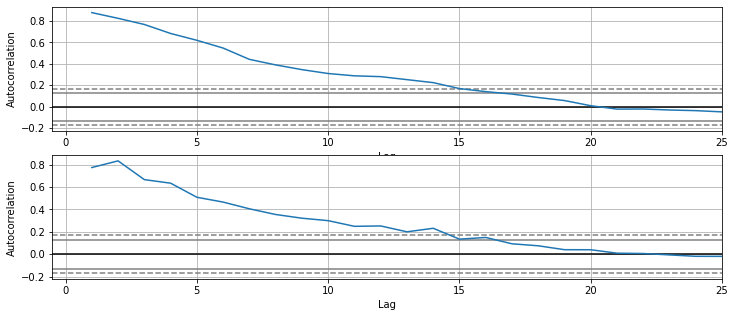

In [13]:
fig, axs = plt.subplots(figsize=(12, 5), nrows=2)

ax = axs[0]
pd.plotting.autocorrelation_plot(
    data_daily_df.query('ticker == "A"').sort_values(by="date")["return_d_p2_pos"],
    **{'ax':ax}
)
ax.set_xlim(-0.5, 25)

ax = axs[1]
pd.plotting.autocorrelation_plot(
    data_daily_df.query('ticker == "A"').sort_values(by="date")["return_d_p2_neg"],
    **{'ax':ax}
)
ax.set_xlim(-0.5, 25)

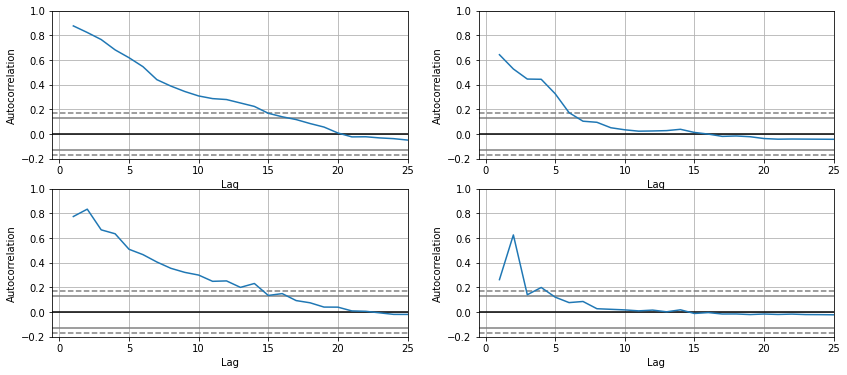

In [14]:
fig, axs = plt.subplots(figsize=(14, 6), nrows=2, ncols = 2)
ticker = 'A'

ax = axs[0,0]
pd.plotting.autocorrelation_plot(
    data_daily_df.query('ticker == @ticker').sort_values(by="date")["return_d_p2_pos"],
    **{'ax':ax}
)

ax = axs[1,0]
pd.plotting.autocorrelation_plot(
    data_daily_df.query('ticker == @ticker').sort_values(by="date")["return_d_p2_neg"],
    **{'ax':ax}
)

ax = axs[0,1]
pd.plotting.autocorrelation_plot(
    data_daily_df.query('ticker == @ticker').sort_values(by="date")["return_d_p4_pos"],
    **{'ax':ax}
)

ax = axs[1,1]
pd.plotting.autocorrelation_plot(
    data_daily_df.query('ticker == @ticker').sort_values(by="date")["return_d_p4_neg"],
    **{'ax':ax}
)

for ax in axs.reshape(-1):
    ax.set_xlim(-0.5, 25)
    ax.set_ylim(-0.2,1)


# HAR

In [15]:
import statsmodels.formula.api as smf

## Explore

In [16]:
data_har_df = data_df.groupby(['ticker', 'date']).aggregate({
    'return_p2': 'sum', 'return_d_p2': 'sum', 'return_j_p2': 'sum'
}).reset_index()

# Realized Vol
data_har_df['rvol_d_1'] = np.sqrt(data_har_df['return_d_p2'])
data_har_df['rvol_d_5'] = data_har_df['rvol_d_1'].rolling(5).mean()
data_har_df['rvol_d_22'] = data_har_df['rvol_d_1'].rolling(22).mean()
data_har_df['rvol_lead'] = np.sqrt(data_har_df['return_p2']).shift(-1)

# Total jumps
data_har_df['sum_jump_p2_1'] = data_har_df['return_j_p2']*78
data_har_df['sum_jump_p2_5'] = data_har_df['sum_jump_p2_1'].rolling(5).mean()
data_har_df['sum_jump_p2_22'] = data_har_df['sum_jump_p2_1'].rolling(22).mean()

data_har_df

,ticker,date,return_p2,return_d_p2,return_j_p2,rvol_d_1,rvol_d_5,rvol_d_22,rvol_lead,sum_jump_p2_1,sum_jump_p2_5,sum_jump_p2_22
0,A,2019-10-01,0.000151,0.000101,0.000050,0.010067,NaN,NaN,0.012138,0.003894,NaN,NaN
1,A,2019-10-02,0.000147,0.000138,0.000010,0.011728,NaN,NaN,0.015082,0.000764,NaN,NaN
2,A,2019-10-03,0.000227,0.000099,0.000128,0.009974,NaN,NaN,0.010061,0.009982,NaN,NaN
3,A,2019-10-04,0.000101,0.000101,0.000000,0.010061,NaN,NaN,0.010329,0.000000,NaN,NaN
4,A,2019-10-07,0.000107,0.000089,0.000018,0.009423,0.010250,NaN,0.016106,0.001396,0.003207,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
22358,T,2020-08-25,0.000026,0.000020,0.000005,0.004499,0.006059,0.007350,0.005568,0.000427,0.000494,0.000348
22359,T,2020-08-26,0.000031,0.000027,0.000004,0.005198,0.005968,0.007215,0.007413,0.000311,0.000556,0.000362
22360,T,2020-08-27,0.000055,0.000049,0.000006,0.006975,0.006012,0.007112,0.005193,0.000491,0.000309,0.000385
22361,T,2020-08-28,0.000027,0.000025,0.000002,0.004971,0.005977,0.006885,0.006796,0.000176,0.000281,0.000393


In [17]:
smf.ols('rvol_lead ~ rvol_d_1 + rvol_d_5  + rvol_d_22',
       data = data_har_df.query('ticker == "AMZN"')).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              rvol_lead   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     141.0
Date:                Thu, 22 Oct 2020   Prob (F-statistic):           1.09e-51
Time:                        15:17:24   Log-Likelihood:                 864.39
No. Observations:                 232   AIC:                            -1721.
Df Residuals:                     228   BIC:                            -1707.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0020      0.001      2.252      0.025       0.000       0.004
rvol_d_1       0.6202      0.082      7.532      0.000       0.458       0.783
rvol_d_5       0.2861      0.111      2.571      0.011       0.067       0.505
rvol_d_22      0.0087      0.086      0.101      0.919      -0.161       0.179
==============================================================================
Omnibus:                       81.019   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              266.953
Skew:                           1.460   Prob(JB):                     1.08e-58
Kurtosis:                       7.369   Cond. No.                         361.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
smf.ols('''
rvol_lead ~ rvol_d_1 + rvol_d_5  + rvol_d_22  +
rvol_d_1:sum_jump_p2_1 + rvol_d_5:sum_jump_p2_1  + rvol_d_22:sum_jump_p2_1
''',
        data = data_har_df.query('ticker == "AMZN"')).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              rvol_lead   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     72.54
Date:                Thu, 22 Oct 2020   Prob (F-statistic):           7.21e-50
Time:                        15:17:24   Log-Likelihood:                 867.54
No. Observations:                 232   AIC:                            -1721.
Df Residuals:                     225   BIC:                            -1697.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0022      0.001      2.443      0.015       0.000       0.004
rvol_d_1                    0.5284      0.092      5.746      0.000       0.347       0.710
rvol_d_5                    0.3674      0.121      3.032      0.003       0.129       0.606
rvol_d_22                  -0.0133      0.094     -0.142      0.887      -0.198       0.171
rvol_d_1:sum_jump_p2_1      9.0376      7.270      1.243      0.215      -5.288      23.363
rvol_d_5:sum_jump_p2_1    -17.2960     10.912     -1.585      0.114     -38.799       4.207
rvol_d_22:sum_jump_p2_1    13.3462     16.129      0.827      0.409     -18.436      45.129
==============================================================================
Omnibus:                       76.766   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              261.874
Skew:                           1.360   Prob(JB):                     1.36e-57
Kurtosis:                       7.437   Cond. No.                     4.69e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## HARs for each stock

In [19]:
data_har_df = (
    data_df.drop(["price", "log_price"], axis=1).groupby(["ticker", "date"]).sum().reset_index()
)

# Realized Vol
data_har_df["rvol_lead"] = data_har_df["return_p2"].shift(-1)

data_har_df["rvol_1"] = data_har_df["return_p2"]
data_har_df["rvol_5"] = data_har_df["rvol_1"].rolling(5).mean()
data_har_df["rvol_22"] = data_har_df["rvol_1"].rolling(22).mean()
    
data_har_df["rvol_d_1"] = data_har_df["return_d_p2"]
data_har_df["rvol_d_5"] = data_har_df["rvol_d_1"].rolling(5).mean()
data_har_df["rvol_d_22"] = data_har_df["rvol_d_1"].rolling(22).mean()

# Total jumps
data_har_df["sum_jump_p2_1"] = data_har_df["return_j_p2"] * 78
data_har_df["sum_jump_p2_5"] = data_har_df["sum_jump_p2_1"].rolling(5).mean()
data_har_df["sum_jump_p2_22"] = data_har_df["sum_jump_p2_1"].rolling(22).mean()

data_har_df

,ticker,date,return,return_p2,return_p4,return_lag1,return_bp,bipower_var_daily,bipower_var_tod,tod_correction,...,rvol_lead,rvol_1,rvol_5,rvol_22,rvol_d_1,rvol_d_5,rvol_d_22,sum_jump_p2_1,sum_jump_p2_5,sum_jump_p2_22
0,A,2019-10-01,-0.025736,0.000151,1.701416e-09,-0.025736,0.000087,0.006902,0.000204,75.999043,...,0.000147,0.000151,NaN,NaN,0.000101,NaN,NaN,0.003894,NaN,NaN
1,A,2019-10-02,-0.009498,0.000147,1.041992e-09,-0.009362,0.000082,0.006514,0.000204,75.999043,...,0.000227,0.000147,NaN,NaN,0.000138,NaN,NaN,0.000764,NaN,NaN
2,A,2019-10-03,0.007951,0.000227,6.477650e-09,0.004561,0.000084,0.006615,0.000204,75.999043,...,0.000101,0.000227,NaN,NaN,0.000099,NaN,NaN,0.009982,NaN,NaN
3,A,2019-10-04,0.019834,0.000101,7.989158e-10,0.018845,0.000064,0.005023,0.000204,75.999043,...,0.000107,0.000101,NaN,NaN,0.000101,NaN,NaN,0.000000,NaN,NaN
4,A,2019-10-07,-0.002660,0.000107,4.300471e-10,-0.002527,0.000061,0.004821,0.000204,75.999043,...,0.000259,0.000107,0.000147,NaN,0.000089,0.000106,NaN,0.001396,0.003207,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22358,T,2020-08-25,-0.006833,0.000026,4.709700e-11,-0.006498,0.000017,0.001319,0.000175,76.046650,...,0.000031,0.000026,0.000045,0.000061,0.000020,0.000038,0.000057,0.000427,0.000494,0.000348
22359,T,2020-08-26,0.006018,0.000031,4.004627e-11,0.005518,0.000022,0.001706,0.000175,76.046650,...,0.000055,0.000031,0.000045,0.000060,0.000027,0.000037,0.000055,0.000311,0.000556,0.000362
22360,T,2020-08-27,-0.006004,0.000055,2.302273e-10,-0.005335,0.000032,0.002489,0.000175,76.046650,...,0.000027,0.000055,0.000042,0.000058,0.000049,0.000038,0.000053,0.000491,0.000309,0.000385
22361,T,2020-08-28,0.004838,0.000027,4.307566e-11,0.003339,0.000015,0.001152,0.000175,76.046650,...,0.000046,0.000027,0.000041,0.000055,0.000025,0.000038,0.000050,0.000176,0.000281,0.000393


In [20]:
results = []

for ticker in tqdm(data_har_df["ticker"].unique()):

    ticker_fit = smf.ols(
        """rvol_lead ~ rvol_d_1 + rvol_d_5  + rvol_d_22 + return_j_p2 + return_j_p2_pos + return_j_p2_neg
    """,
        data=data_har_df.query("ticker == @ticker"),
    ).fit()

    ticker_fit_params = dict(ticker_fit.params[1:])
    ticker_results = {**{"ticker": ticker}, **ticker_fit_params}

    results.append(ticker_results)

results_df = pd.DataFrame(results)

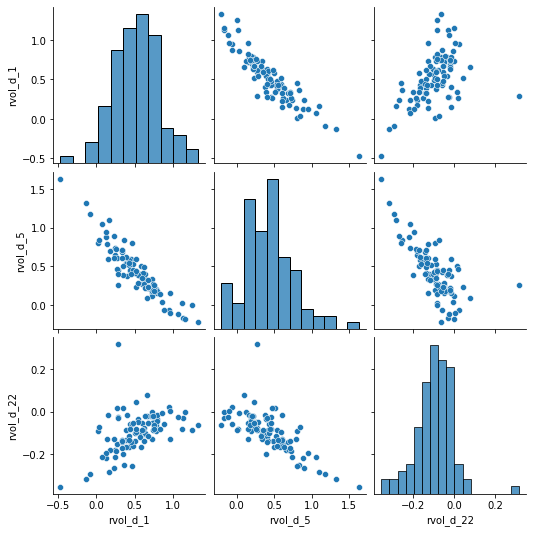

In [21]:
sns.pairplot(results_df.set_index('ticker').iloc[:,0:3])

In [22]:
# Melt dataframe and add average daily (sum J^2) for each ticker
results_melt_df = results_df.melt(id_vars="ticker", var_name="rvol_type", value_name="beta")
results_melt_df = results_melt_df.merge(
    data_har_df.groupby(["ticker"])
    .sum()
    .reset_index(),
    on="ticker",
    how="left",
)
results_melt_df.head()

,ticker,rvol_type,beta,return,return_p2,return_p4,return_lag1,return_bp,bipower_var_daily,bipower_var_tod,...,rvol_lead,rvol_1,rvol_5,rvol_22,rvol_d_1,rvol_d_5,rvol_d_22,sum_jump_p2_1,sum_jump_p2_5,sum_jump_p2_22
0,A,rvol_d_1,0.574863,0.308698,0.080251,0.000009,0.298130,0.047164,3.713792,0.047182,...,0.080530,0.080251,0.079770,0.077605,0.074806,0.074429,0.072465,0.424672,0.416605,0.400953
1,AAL,rvol_d_1,0.401500,-0.807169,0.540460,0.000391,-0.893907,0.338425,26.645305,0.338582,...,0.540169,0.540460,0.538664,0.527722,0.480313,0.478511,0.468393,4.691461,4.691961,4.627653
2,AAP,rvol_d_1,0.791172,-0.178679,0.185997,0.000058,-0.104159,0.113839,8.951911,0.113875,...,0.186066,0.185997,0.187364,0.197218,0.167024,0.168592,0.177858,1.479895,1.464232,1.510058
3,AAPL,rvol_d_1,0.433788,0.371936,0.082320,0.000009,0.372719,0.049169,3.868541,0.049180,...,0.082504,0.082320,0.082139,0.082113,0.074596,0.074406,0.074209,0.602492,0.603180,0.616461
4,ABBV,rvol_d_1,0.953413,0.130865,0.102162,0.000015,0.160529,0.061458,4.830776,0.061478,...,0.102055,0.102162,0.102747,0.104254,0.096235,0.096681,0.098136,0.462328,0.473174,0.477215


In [23]:
fits = []

for rvol_type in results_melt_df["rvol_type"].unique():
    if 'rvol' not in rvol_type:
        continue
        
    fit = smf.ols(
        "beta ~ return_j_p2", 
        data=results_melt_df.query("rvol_type == @rvol_type")
    ).fit()
    print(rvol_type)
    fit_df = pd.DataFrame([fit.params, fit.pvalues], index=["coef", "p"]).T
    fit_df["p"] = fit_df["p"].round(4)
    display(fit_df)
    print("\n====\n")

rvol_d_1


,coef,p
Intercept,0.585987,0.0000
return_j_p2,-3.689064,0.0919



====

rvol_d_5


,coef,p
Intercept,0.357422,0.0000
return_j_p2,4.458552,0.0542



====

rvol_d_22


,coef,p
Intercept,-0.084638,0.0000
return_j_p2,-0.632489,0.3335



====



In [24]:
fits = []

for rvol_type in results_melt_df["rvol_type"].unique():
    if 'rvol' not in rvol_type:
        continue
    
    fit = smf.ols(
        "beta ~ return_j_p2_pos + return_j_p2_neg", 
        data=results_melt_df.query("rvol_type == @rvol_type")
    ).fit()
    print(rvol_type)
    fit_df = pd.DataFrame([fit.params, fit.pvalues], index=["coef", "p"]).T
    fit_df["p"] = fit_df["p"].round(4)
    display(fit_df)
    print("\n====\n")

rvol_d_1


,coef,p
Intercept,0.573206,0.0000
return_j_p2_pos,12.466875,0.0602
return_j_p2_neg,-22.442471,0.0036



====

rvol_d_5


,coef,p
Intercept,0.371796,0.0000
return_j_p2_pos,-13.710916,0.0493
return_j_p2_neg,25.549212,0.0016



====

rvol_d_22


,coef,p
Intercept,-0.086803,0.0000
return_j_p2_pos,2.103542,0.2995
return_j_p2_neg,-3.808405,0.1024



====



In [25]:
fits = []

for rvol_type in results_melt_df["rvol_type"].unique():
    if 'rvol' not in rvol_type:
        continue
    
    fit = smf.ols(
        "beta ~ return_j_pos + return_j_neg", 
        data=results_melt_df.query("rvol_type == @rvol_type")
    ).fit()
    print(rvol_type)
    fit_df = pd.DataFrame([fit.params, fit.pvalues], index=["coef", "p"]).T
    fit_df["p"] = fit_df["p"].round(4)
    display(fit_df)
    print("\n====\n")

rvol_d_1


,coef,p
Intercept,0.729133,0.0000
return_j_pos,0.446906,0.0562
return_j_neg,0.871249,0.0023



====

rvol_d_5


,coef,p
Intercept,0.228024,0.0265
return_j_pos,-0.367721,0.1426
return_j_neg,-0.778750,0.0106



====

rvol_d_22


,coef,p
Intercept,-0.082641,0.0062
return_j_pos,0.015249,0.8341
return_j_neg,0.038987,0.6557



====



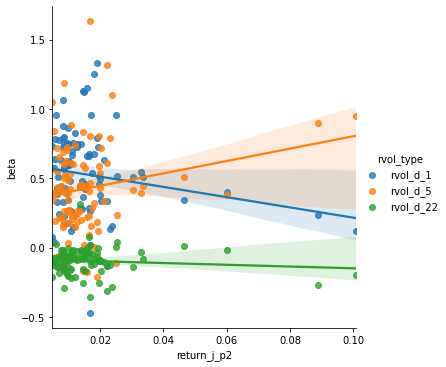

In [27]:
sns.lmplot(
    x="return_j_p2",
    y="beta",
    hue="rvol_type",
    data=results_melt_df.loc[results_melt_df["rvol_type"].apply(lambda x: "rvol" in x)],
)